In [1]:
from osgeo import gdal, osr
import numpy as np

In [2]:
%cd /home/ayush12gupta/Desktop/ugp/new/merged

/home/ayush12gupta/Desktop/ugp/new/merged


In [6]:
!pip install netCDF4

     |████████████████████████████████| 4.7 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 238 kB 16.3 MB/s eta 0:00:01


In [3]:
import os
from osgeo import gdal
from osgeo import osr
import numpy

def plotdata(GDALfilename, band=1,
             title=None,colormap='gray',
             aspect=1, background=None,
             datamin=None, datamax=None,
             interpolation='nearest',
             nodata = None,
             draw_colorbar=True, colorbar_orientation="horizontal"):
    
    # Read the data into an array
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    data = ds.GetRasterBand(band).ReadAsArray()
    print(data.shape)
    transform = ds.GetGeoTransform()
    ds = None
    
    try:
        if nodata is not None:
            data[data == nodata] = np.nan
    except:
        pass
        
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+data.shape[1]*deltax
    lasty = firsty+data.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])

    # put all zero values to nan and do not plot nan
    if background is None:
        try:
            data[data==0]=np.nan
        except:
            pass
    
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(111)
    cax = ax.imshow(data, vmin = datamin, vmax=datamax,
                    cmap=colormap, extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax.set_title(title)
    if draw_colorbar is not None:
        cbar = fig.colorbar(cax,orientation=colorbar_orientation)
    ax.set_aspect(aspect)    
    plt.show()
    
    # clearing the data
    data = None
    
# config
GDAL_DATA_TYPE = gdal.GDT_Float64 
GEOTIFF_DRIVER_NAME = "GTiff"
NO_DATA = -32767
SPATIAL_REFERENCE_SYSTEM_WKID = 32767

def create_raster(output_path,
                  columns,
                  rows,
                  nband = 1,
                  gdal_data_type = GDAL_DATA_TYPE,
                  driver = GEOTIFF_DRIVER_NAME):

    driver = gdal.GetDriverByName(driver)

    output_raster = driver.Create(output_path, int(columns), int(rows), nband, eType = gdal_data_type)    
    return output_raster

def numpy_array_to_raster(output_path,
                          numpy_array,
                          proj,
                          trans,
                          nband = 1,
                          no_data = NO_DATA,
                          gdal_data_type = GDAL_DATA_TYPE,
                          spatial_reference_system_wkid = SPATIAL_REFERENCE_SYSTEM_WKID,
                          driver = GEOTIFF_DRIVER_NAME):


    rows, columns = numpy_array.shape
    output_raster = create_raster(output_path, int(columns), int(rows), nband, gdal_data_type) 
    geotransform = trans
    print(geotransform)

    spatial_reference = osr.SpatialReference()
    spatial_reference.ImportFromWkt(proj)
    # spatial_reference.ImportFromProj4('+proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=95 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
    output_raster.SetProjection(spatial_reference.ExportToWkt())
    output_raster.SetGeoTransform(geotransform)
    output_band = output_raster.GetRasterBand(1)
    output_band.SetNoDataValue(no_data)
    output_band.WriteArray(numpy_array)          
    output_band.FlushCache()
    print(output_raster.GetProjection())
    
    return  output_raster

In [28]:
import osgeo.osr as osr

import netCDF4
file2read = netCDF4.Dataset('exp_nc_G0028V02_P095.nc','r')
print(file2read.variables.keys())

vx = np.array(file2read['v']).astype(float)
vx[vx==-32767] = np.nan
vy = np.array(file2read['va']).astype(float)
vy[vy==-32767] = np.nan

odict_keys(['img_pair_info', 'x', 'y', 'mapping', 'vx', 'vy', 'v', 'v_error', 'vr', 'va', 'M11', 'M12', 'chip_size_width', 'chip_size_height', 'interp_mask'])


In [26]:
from shutil import copyfile, move # Utilities for copying and moving files
from osgeo import gdal            # GDAL support for reading virtual files
import os                         # To create and remove directories
import matplotlib.pyplot as plt   # For plotting
import numpy as np                # Matrix calculations
deg2rad = np.pi/360

def plotcomplexdata(GDALfilename,
                    title=None, aspect=1,
                    datamin=None, datamax=None,
                    interpolation='nearest',
                    draw_colorbar=None, colorbar_orientation="horizontal"):
    
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    slc = ds.GetRasterBand(1).ReadAsArray()
    
    transform = ds.GetGeoTransform()
    ds = None
    
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+slc.shape[1]*deltax
    lasty = firsty+slc.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])
    
    # put all zero values to nan and do not plot nan
    try:
        slc[slc==0]=np.nan
    except:
        pass
    
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(1,2,1)
    cax1=ax.imshow(np.abs(slc), vmin = datamin, vmax=datamax,
                   cmap='gray', extent=[xmin,xmax,ymin,ymax],
                   interpolation=interpolation)
    ax.set_title(title + " (amplitude)")
    if draw_colorbar is not None:
        cbar1 = fig.colorbar(cax1,orientation=colorbar_orientation)
    ax.set_aspect(aspect)

    ax = fig.add_subplot(1,2,2)
    cax2 =ax.imshow(np.angle(slc), cmap='rainbow',
                    vmin=-np.pi, vmax=np.pi,
                    extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax.set_title(title + " (phase [rad])")
    if draw_colorbar is not None:
        cbar2 = fig.colorbar(cax2, orientation=colorbar_orientation)
    ax.set_aspect(aspect)
    plt.show()
    
    # clearing the data
    slc = None

In [14]:
!ls ./ion_cal

azshift.ion	 raw.cor      raw_no_projection.cor
azshift.ion.vrt  raw.cor.vrt  raw_no_projection.cor.vrt
azshift.ion.xml  raw.cor.xml  raw_no_projection.cor.xml
filt.ion	 raw.ion      raw_no_projection.ion
filt.ion.vrt	 raw.ion.vrt  raw_no_projection.ion.vrt
filt.ion.xml	 raw.ion.xml  raw_no_projection.ion.xml


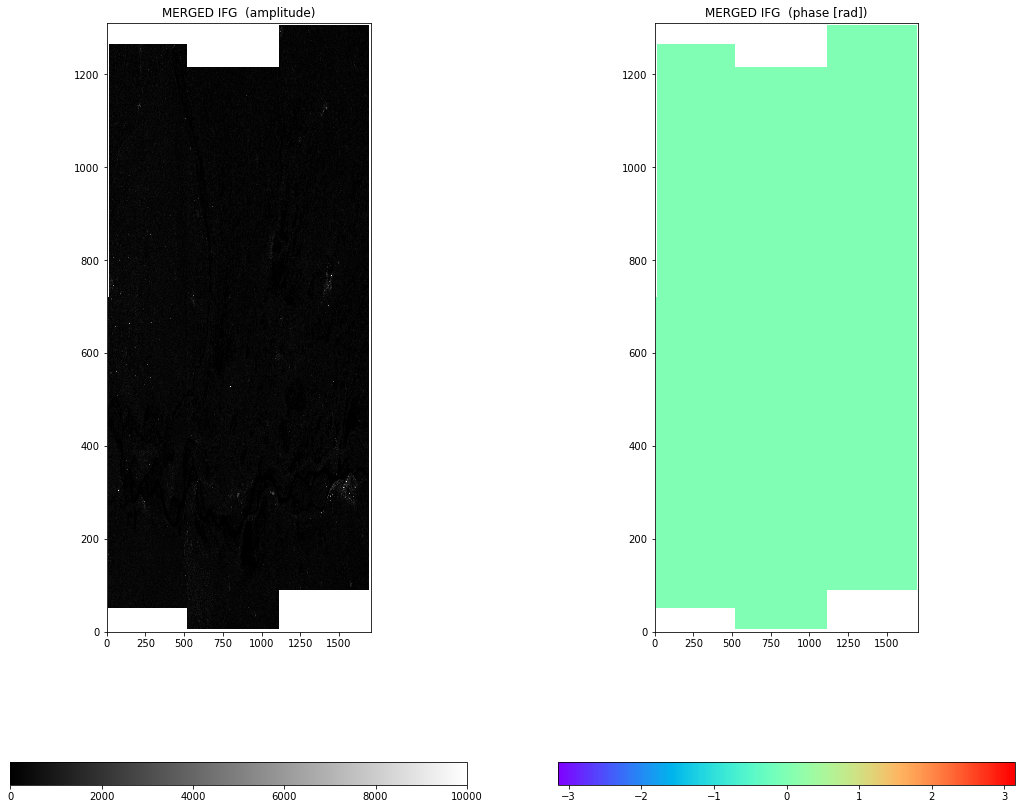

In [27]:
plotcomplexdata('/home/ayush12gupta/Desktop/ugp/PanoplyJ/ion_cal/raw_no_projection.ion.vrt',
                title="MERGED IFG ", aspect=3,
                datamin=0, datamax=10000, draw_colorbar=True)

In [11]:
# ds = gdal.Open('ssm.tif')
ds = gdal.Open('filt_topophase.unw.geo')
# projs = ds.GetProjection()
# ds = gdal.Open('../refvel_y.tif')
projs = ds.GetProjection()
geo = ds.GetGeoTransform()
# srs = ds.GetSpatialRef()
# projs
band = ds.GetRasterBand(2).ReadAsArray()
# band.shape
geo
# (1174, 2546)
# band = np.absolute(band)
# ds2 = gdal.Open('window_chip_size_min.tif')
# # ds = gdal.Open('velocity.tif')
# projs = ds.GetProjection()
# geo = ds.GetGeoTransform()
# band2 = ds2.GetRasterBand(1).ReadAsArray()

(84.77916666666667,
 0.0002777777777777778,
 0.0,
 26.889444444444443,
 0.0,
 -0.0002777777777777778)

In [40]:
deg2rad = np.pi/180
band = band.astype(float) * deg2rad
band = np.tan(band)
band.max()
# b = np.array([1, 2, 3])

0.027262715267471347

In [19]:
import scipy.io, cv2
f = scipy.io.loadmat('offset.mat')
band = f['Dx']

In [1]:
# band.min()
# !ls

In [62]:
chipmin_x = band.copy()
import math
for i in range(len(chipmin_x)):
    for j in range(len(chipmin_x[i])):
#         if math.isnan(chipmin_x[i][j]):
            chipmin_x[i][j] = 0

In [65]:
# chipmin[chipmin]
for i in range(len(chipmin_x)):
    for j in range(len(chipmin_x[i])):
        if band[i][j]>60:
            chipmin_x[i][j] = 240
        elif band[i][j]<=60 and band[i][j]>30:
            chipmin_x[i][j] = 480
        elif band[i][j]<=30 and band[i][j]>15:
            chipmin_x[i][j] = 960
        elif band[i][j]<=15 and band[i][j]>0:
            chipmin_x[i][j] = 1920
#         elif math.isnan(chipmin_x[i][j]):
#             chipmin_x[i][j] = 240
# chipmin_x[band>100]
# chipmin_x[]        

In [52]:
chipmax_x = np.zeros_like(band)
for i in range(len(chipmin_x)):
    for j in range(len(chipmin_x[i])):
        if band[i][j]>70:
            chipmax_x[i][j] = 480
        elif band[i][j]<=70 and band[i][j]>20:
            chipmax_x[i][j] = 960
        elif band[i][j]<=20 and band[i][j]>0:
            chipmax_x[i][j] = 1920
        elif math.isnan(chipmin_x[i][j]):
            chipmax_x[i][j] = 1920

In [53]:
ds = gdal.Open('velocity.tif')
# ds = gdal.Open('window_location.tif')
projs = ds.GetProjection()
band = ds.GetRasterBand(1).ReadAsArray()
geo = ds.GetGeoTransform()
# band.shape
# ndata
# (2869, 3283)

In [51]:
# band = band.astype(float64)
# band[band==-32767] = 0
# band = np.absolute(band)
# np.any(np.mod()==0)
# np.mod(ChipSizeUniX, 68)
band

In [40]:
# import math
# cnt=0
# for i in range(len(band)):
#     for j in range(len(band[i])):
#         if math.isnan(band[i][j]):
# #             band[i][j] = -32767
#             cnt+=1
# cnt
ChipSizeUniX = np.unique(np.append(np.unique(band2), np.unique(band)))
ChipSizeUniX = np.delete(ChipSizeUniX,np.where(ChipSizeUniX == 0)[0])
ChipSizeUniX
# np.unique(band)
# np.unique(band)
# ds.GetNoDataValue()
# band.max()
# band[band>1000].max()

array([-32767,     36,     72,    144,    288], dtype=int32)

In [63]:
data.max()

12875.0

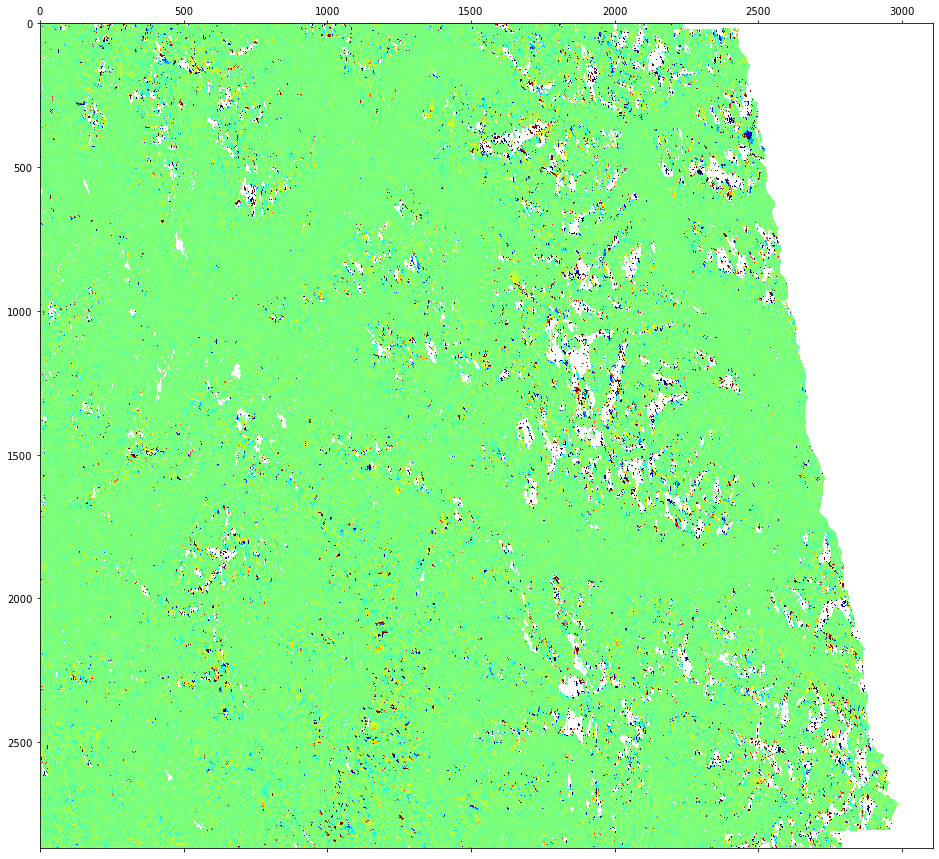

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np

some_matrix = vy.copy() #.astype(float)
# some_matrix = chipmax_x.copy()
# some_matrix[some_matrix<15] = np.nan
# some_matrix[band < -15] = band[band < -15]
# f['Dy']

plt.matshow(some_matrix,  cmap='jet', interpolation='nearest',
               vmin=-2000, vmax=2000)  #cmap
plt.rcParams['figure.figsize'] = [600, 400]
plt.show()

# import numpy as np
# import math
# from matplotlib import pyplot as plt
# %matplotlib inline

# # data = np.random.normal(0, 20, 1000) 
# data = vy[(vy>15)&(vy<200)].copy()
# bins = np.linspace(math.ceil(min(data)), 
#                    math.floor(max(data)), 200) # fixed number of bins

# plt.xlim([min(data)-5, max(data)+5])
# plt.hist(data, bins=bins, alpha=0.5)
# plt.title('Random Gaussian data (fixed number of bins)')
# plt.xlabel('variable X (20 evenly spaced bins)')
# plt.ylabel('count')
# plt.show()

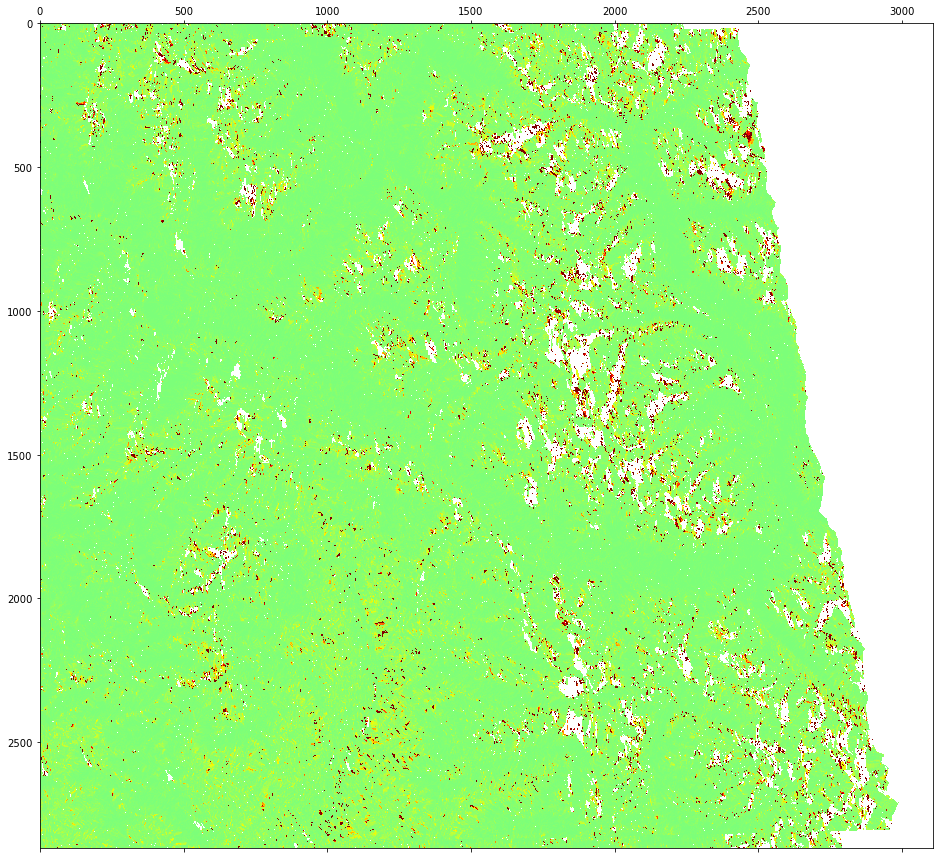

In [29]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import numpy as np

# some_matrix = b.copy() #.astype(float)
some_matrix = vx.copy()
# some_matrix[some_matrix<15] = np.nan
# some_matrix[band < -15] = band[band < -15]
# f['Dy']

plt.matshow(some_matrix,  cmap='jet', interpolation='nearest',
               vmin=-2000, vmax=2000)  #cmap
plt.rcParams['figure.figsize'] = [600, 400]
plt.show()

In [81]:
vy[vy>0].mean()
# vvy = vy.copy()

151.8878575119072

In [82]:
vvy[vvy>0].mean()


151.8878575119072

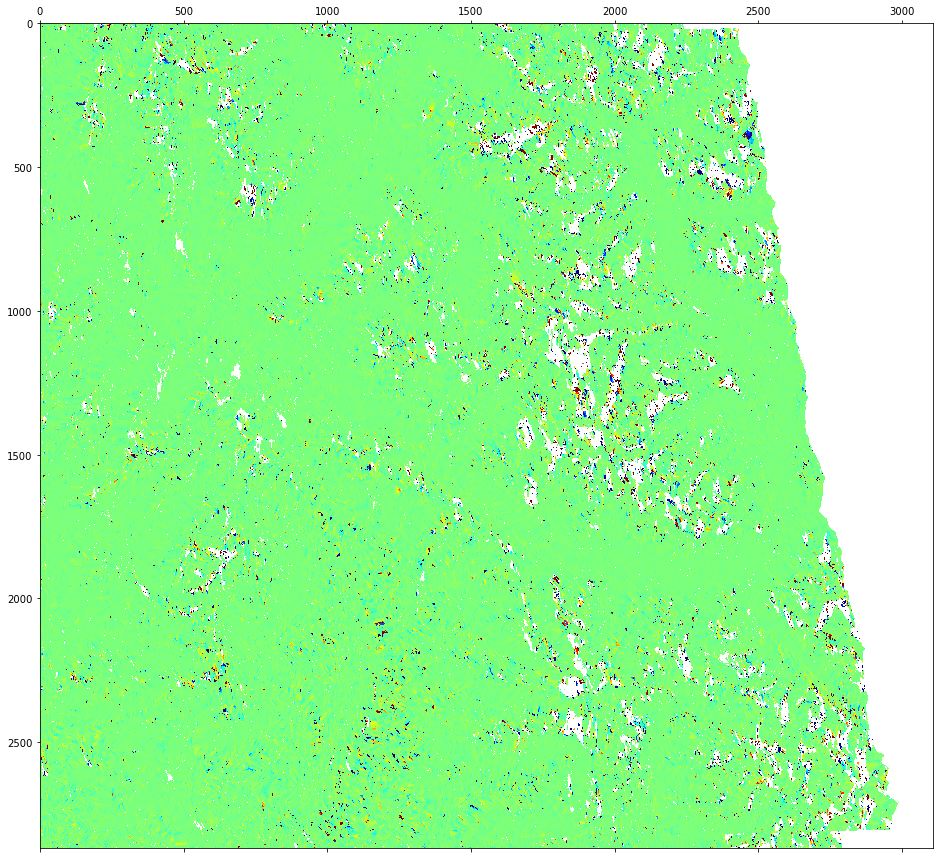

In [73]:
some_matrix = vy.copy()
# some_matrix = np.absolute(some_matrix)
# chipmin_x.copy()
# some_matrix[some_matrix<15] = np.nan
# some_matrix[band < -15] = band[band < -15]
# f['Dy']

plt.matshow(some_matrix,  cmap='jet', interpolation='nearest',
               vmin=-2000, vmax=2000)  #cmap
plt.rcParams['figure.figsize'] = [600, 400]
plt.show()

In [5]:
pwd

'/home/ayush12gupta/Desktop/ugp/new/merged'

In [12]:
# band# ar = np.zeros([2871, 3285])
# ar[:1] = -0.0
# ar[-1:] = -0.0
# ar[:, :1] = -0.0
# ar[:, -1:] = -0.0
# ar[1:-1, 1:-1] = band
output_path = 'unwphase.tif'
ds = numpy_array_to_raster(output_path, band, projs, geo)
ds.FlushCache()
ds = None
# ar.min()

(84.77916666666667, 0.0002777777777777778, 0.0, 26.889444444444443, 0.0, -0.0002777777777777778)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
